In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import yfinance as yf
import pickle
import os
import math
from ReferentialData.polygonData import PolygonAPI
from DataAnalysis.DataExtensions import *
from Filtering.KalmanFilter import KalmanFilter
import glob

Load Data

In [2]:
DIR = r'C:\Users\raymo\OneDrive\Desktop\Ray Stuff\_Cache'
root_dir = r'C:\Users\raymo\OneDrive\Desktop\Playground\Financial-Modelling-Playground\Quant_Trading\Histo'
COR_DIR = r'\Users\raymo\OneDrive\Desktop\Playground\Financial-Modelling-Playground\Quant_Trading\Clustering'

In [16]:
# Tickers to Load
UNIVERSE = list(pd.read_csv(os.path.join(root_dir, 'clean_names.csv'))['0'])
# UNIVERSE = ['AAPL']
## End Date
end_dt = "2025-01-01"
## Start date
start_dt = "2020-01-01"

In [4]:
colnames = ["Close", "Volume"]
DataLoader = PolygonAPI()
MID_LOADED = False
HIGH_LOADED = False
if not MID_LOADED:
    mid_df = {}
if not HIGH_LOADED:
    high_df = {}
# ### loading in low frequency data
# if len(mid_df) == 0:
#     mid_df = DataLoader.getPrices(UNIVERSE, "day", logDir=os.path.join(DIR,"Beta_Callibration"), _parallel=True)
#     MID_LOADED = True

### loading in high frequency data
if len(high_df) == 0:
    high_df = DataLoader.getPrices(UNIVERSE, timespan="hour", 
                                   from_ = start_dt, 
                                   to_=end_dt, logDir=DIR, override=False, _parallel=True)
    HIGH_LOADED = True

In [5]:
def get_unixtime(dt64):
    return dt64.astype('datetime64[s]').astype('int')

daily_dt = 10e3*60*60*24
min_dt = 10e3*60
dt_ratio = daily_dt / min_dt 


def getTimeDiffs(dt_list: np.array):
    ## case to ms unix tyime
    if type(dt_list[0]) == np.datetime64:
        dt_list = get_unixtime(dt_list)
    shifted_dt = np.roll(dt_list, 1)
    res = dt_list - shifted_dt
    res[0] = 0 ## as this makes no sense
    return res

logReturnTransform = lambda df : np.log(df.loc[:,~df.columns.str.contains('timestamp')]) - np.log(df.loc[:,~df.columns.str.contains('timestamp')]).shift(1)
def logRetDtDailyTransform(df):
    return logReturnTransform(df.loc[:,~df.columns.str.contains('timestamp')]).apply(
        lambda col: np.asarray(col) / getTimeDiffs(np.asarray(df.index.values)) *math.sqrt(dt_ratio))


# Cross Sectional Analysis

### EOD vs EOW

{1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 43.0, 44.0, 46.0, 47.0, 50.0, 52.0, 2101.0, 54.0, 55.0, 2102.0, 57.0, 60.0, 64.0, 180.0, 181.0, 187.0, 4801.0, 4802.0, 3301.0, nan, 3361.0, 3362.0, 3363.0, 3364.0, 3372.0, 3421.0, 4981.0, 1921.0, 1923.0, 3541.0, 3542.0, 481.0, 482.0, 483.0, 484.0, 485.0, 486.0, 487.0, 488.0, 489.0, 495.0, 496.0, 497.0, 501.0, 504.0}


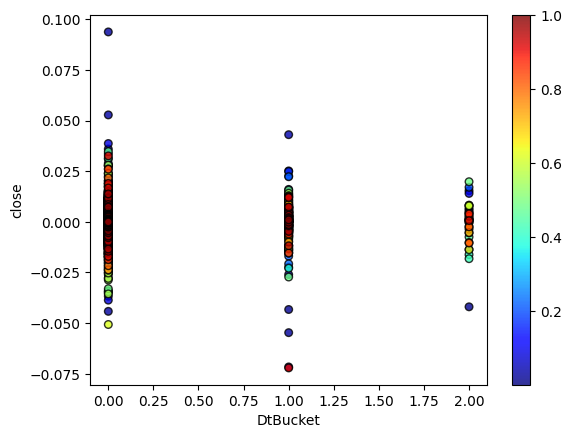

In [ ]:
### Cross-Sectional Analysis 

### time delta indication that it's CLOSE - OPEN (standard day): 9am = 33:00, 4:30pm = 16:30
CLOSE_OPEN_DELTA = (33 - 16.5) * 60
### time delta indication that it's WEEKEND: CLOSE_OPEN_DELTA + 48 HRS
CLOSE_OPEN_WEEKEND_DELTA = CLOSE_OPEN_DELTA + 48 * 60

WeekdayDeltaMask = lambda dt: dt < CLOSE_OPEN_WEEKEND_DELTA and dt > CLOSE_OPEN_DELTA
WeekendDeltaMask = lambda dt: dt > CLOSE_OPEN_WEEKEND_DELTA

test = logReturnTransform(high_df[0]['AAPL'].drop('otc',axis=1))
test['timestamp'] = high_df[0]['AAPL']['timestamp']
test['TimeDelta'] =  (high_df[0]['AAPL']['timestamp'] - high_df[0]['AAPL']['timestamp'].shift(1)).values / (60 * 1000)
test['DtBucket'] = test.apply(lambda dr: int(WeekdayDeltaMask(dr['TimeDelta'])) + 2*int(WeekendDeltaMask(dr['TimeDelta'])), axis=1)
# test = test[test['TimeDelta'] > 1]
print(set(test['TimeDelta']))
scatterHeat('DtBucket', 'close', 'timestamp', test)

### WEEKDAY EOD ANALYSIS

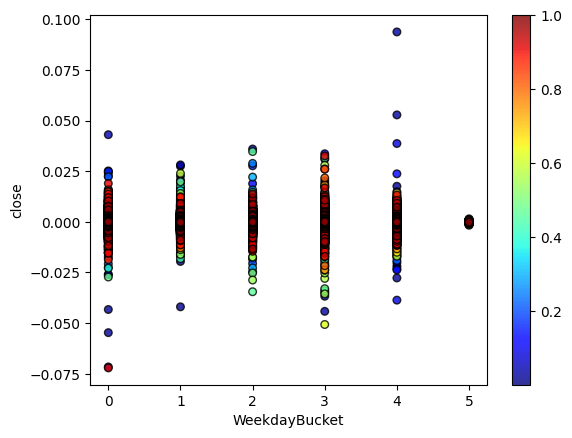

In [9]:
test['WeekdayBucket'] = [pd.to_datetime(date, unit='ms').weekday() for date in test['timestamp']]
scatterHeat('WeekdayBucket', 'close', 'timestamp', test)

C:\Users\raymo\AppData\Local\Temp\ipykernel_17644\3433934393.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intra_test['WeekdayBucket'] = [pd.to_datetime(date, unit='ms').weekday() for date in intra_test['timestamp']]


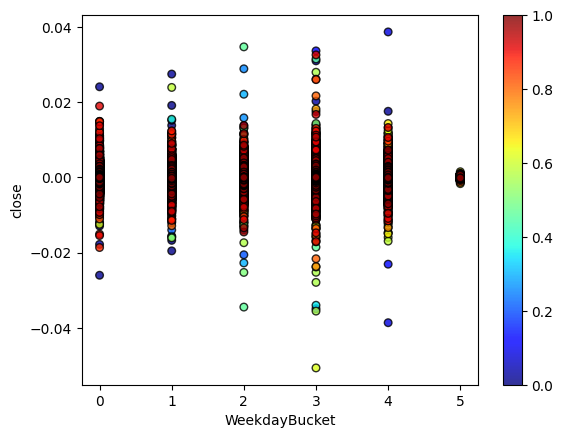

In [11]:
### intraday filter
intra_test = test[test['TimeDelta'] < 10]
intra_test['WeekdayBucket'] = [pd.to_datetime(date, unit='ms').weekday() for date in intra_test['timestamp']]
# plt.scatter(intra_test['WeekdayBucket'], intra_test['close'])
scatterHeat('WeekdayBucket', 'close', 'timestamp', intra_test)

In [23]:
weekday_vol_summary = {}

from enum import Enum

class Weekday(Enum):
    MONDAY = 0
    TUESDAY = 1
    WEDNESDAY = 2
    THURSDAY = 3
    FRIDAY = 4
    SATURDAY = 5
    SUNDAY = 6

for i in range(0,6):
    weekday_df = intra_test[intra_test['WeekdayBucket']==i]
    weekday_vol_summary[Weekday(i)] = weekday_df['close'].describe()

pd.DataFrame(weekday_vol_summary).transpose()

,count,mean,std,min,25%,50%,75%,max
Weekday.MONDAY,180611.0,5.562108e-06,0.000730,-0.026034,-0.000253,0.0,0.000263,0.024062
Weekday.TUESDAY,201896.0,-2.674840e-07,0.000705,-0.019554,-0.000257,0.0,0.000263,0.027445
Weekday.WEDNESDAY,201141.0,-5.551278e-08,0.000716,-0.034495,-0.000264,0.0,0.000267,0.034676
Weekday.THURSDAY,199155.0,-8.058761e-07,0.000817,-0.050668,-0.000270,0.0,0.000273,0.033605
Weekday.FRIDAY,192049.0,1.521486e-07,0.000737,-0.038646,-0.000251,0.0,0.000257,0.038646
Weekday.SATURDAY,3072.0,9.615216e-07,0.000218,-0.001685,-0.000085,0.0,0.000102,0.001483


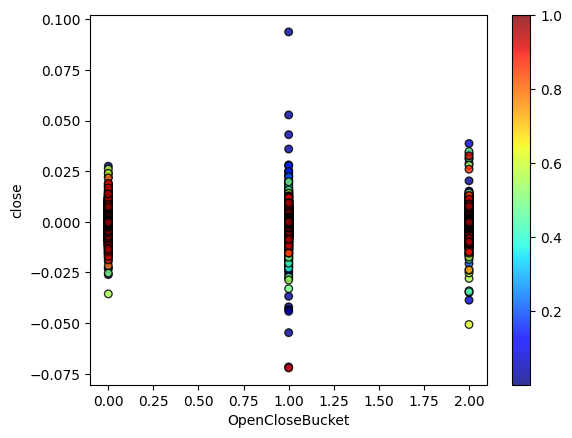

In [15]:
### intraday filter and end of day filter
test['OpenCloseBucket'] = [int(pd.to_datetime(date, unit='ms').hour < 10)
                               + 2 *int(pd.to_datetime(date, unit='ms').hour > 15) for date in test['timestamp']]
# plt.scatter(intra_test['OpenCloseBucket'], test['close'])
scatterHeat('OpenCloseBucket', 'close', 'timestamp', test)


C:\Users\raymo\AppData\Local\Temp\ipykernel_17644\1885009039.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inter_test['WeekdayBucket'] = [pd.to_datetime(date, unit='ms').weekday() for date in inter_test['timestamp']]


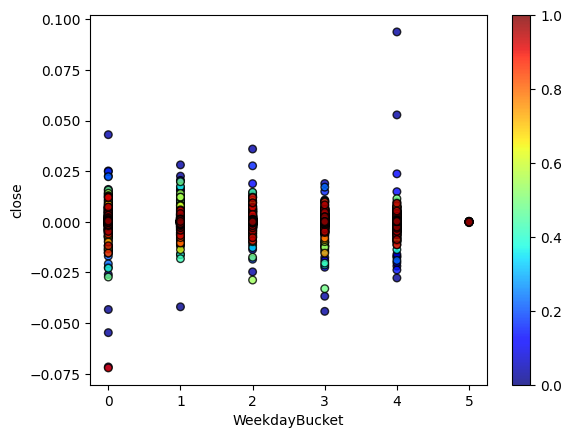

,count,mean,std,min,25%,50%,75%,max
Weekday.MONDAY,518.0,-0.000176,0.007774,-0.072093,-0.000533,0.000049,0.000966,0.043008
Weekday.TUESDAY,633.0,0.000275,0.004312,-0.041938,-0.000535,0.000000,0.000726,0.028110
Weekday.WEDNESDAY,683.0,0.000380,0.003814,-0.028716,-0.000434,0.000092,0.000770,0.035932
Weekday.THURSDAY,653.0,-0.000080,0.004302,-0.044171,-0.000474,0.000026,0.000791,0.018902
Weekday.FRIDAY,692.0,0.000034,0.005369,-0.027696,-0.000481,0.000000,0.000618,0.093715
Weekday.SATURDAY,14.0,-0.000013,0.000172,-0.000391,-0.000109,-0.000036,0.000076,0.000282


In [ ]:
inter_test = test[test['TimeDelta'] > 10]
inter_test['WeekdayBucket'] = [pd.to_datetime(date, unit='ms').weekday() for date in inter_test['timestamp']]
# plt.scatter(intra_test['WeekdayBucket'], intra_test['close'])
scatterHeat('WeekdayBucket', 'close', 'timestamp', inter_test)
weekday_vol_summary = {}

from enum import Enum

class Weekday(Enum):
    MONDAY = 0
    TUESDAY = 1
    WEDNESDAY = 2
    THURSDAY = 3
    FRIDAY = 4
    SATURDAY = 5
    SUNDAY = 6

for i in range(0,6):
    weekday_df = inter_test[inter_test['WeekdayBucket']==i]
    weekday_vol_summary[Weekday(i)] = weekday_df['close'].describe()

pd.DataFrame(weekday_vol_summary).transpose()

In [28]:
weekday_vol_summary[Weekday(0)]/math.sqrt(2)

count    366.281313
mean      -0.000124
std        0.005497
min       -0.050977
25%       -0.000377
50%        0.000035
75%        0.000683
max        0.030411
Name: close, dtype: float64

In [ ]:
### avg of intraday return
print('Intraday Avg Return:', intra_test['close'].mean())
print('Intraday Std Return:', intra_test['close'].std())

### avg of inteday return - not over weekend
print('Interday Avg Return:', inter_test[inter_test['WeekdayBucket'] != 0]['close'].mean())
print('Interday Std Return:', inter_test[inter_test['WeekdayBucket'] != 0]['close'].std())

### avg of inteday return - weekend
print('Weekend Avg Return:', inter_test[inter_test['WeekdayBucket'] == 0]['close'].mean())
print('Weekend Std Return:', inter_test[inter_test['WeekdayBucket'] == 0]['close'].std())

print('Avg Ratio of Intra to Daily Return', (inter_test[inter_test['WeekdayBucket'] != 0]['close'].mean() / 
      intra_test['close'].mean()
      ))

print('Std Ratio of Intra to Daily Return', (inter_test[inter_test['WeekdayBucket'] != 0]['close'].std()
      / intra_test['close'].std()
      )**2)


print('Avg Ratio of Intra to Daily Return', (inter_test[inter_test['WeekdayBucket'] == 0]['close'].mean() / 
      inter_test[inter_test['WeekdayBucket'] != 0]['close'].mean()
      ))

print('Std Ratio of Intra to Daily Return', (inter_test[inter_test['WeekdayBucket'] == 0]['close'].std() / 
      inter_test[inter_test['WeekdayBucket'] != 0]['close'].std()
      )**2)

Intraday Avg Return: 8.29397260070419e-07
Intraday Std Return: 0.0007409771658829512
Interday Avg Return: 0.00015146690372749283
Interday Std Return: 0.004483164657512141
Weekend Avg Return: -0.00017605059879692526
Weekend Std Return: 0.007774329218338058
Avg Ratio of Intra to Daily Return 182.62286484360064
Std Ratio of Intra to Daily Return 36.60662835081435
Avg Ratio of Intra to Daily Return -1.1623040708197314
Std Ratio of Intra to Daily Return 3.007159581871182
